# UniverSeg: Universal Medical Image Segmentation



> For GPU acceleration go to Edit > Notebook Settings  and for Hardware Accelerator select GPU


### 1. Setup

First, we clone the repo, install necessary dependencies, and download the pretrained model

In [1]:
!git clone https://github.com/JJGO/UniverSeg
!python -m pip install -r ./UniverSeg/requirements.txt

Cloning into 'UniverSeg'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 121 (delta 43), reused 91 (delta 23), pack-reused 0
Receiving objects: 100% (121/121), 18.62 MiB | 20.63 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 1.0 MB/s eta 0:00:00


In [2]:
import sys
sys.path.append('UniverSeg')

import math
import itertools

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from universeg import universeg
model = universeg(pretrained=True)
_ = model.to(device)

Downloading: "https://github.com/JJGO/UniverSeg/releases/download/weights/universeg_v1_nf64_ss64_STA.pt" to /root/.cache/torch/hub/checkpoints/universeg_v1_nf64_ss64_STA.pt
100%|██████████| 4.53M/4.53M [00:00<00:00, 47.6MB/s]


In [4]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))
    
    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    
    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])
    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
    
    if title:
        plt.suptitle(title, fontsize=20)
            
    plt.tight_layout()

---



# 2. Example Data: White Blood Cell Segmentation

We show UniverSeg's capabilities to segment out-of-distribution data not seen during training, given a support set of image-segmentation pairs. We work with a White Blood Cell segmentation dataset \[1\]

\[1\] https://github.com/zxaoyou/segmentation_WBC

In [5]:
from example_data.wbc import WBCDataset

d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
d_test = WBCDataset('JTSC', split='test', label='cytoplasm')

n_support = 64

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

We visualize some examples we are going to use as **Support** to encode the task description

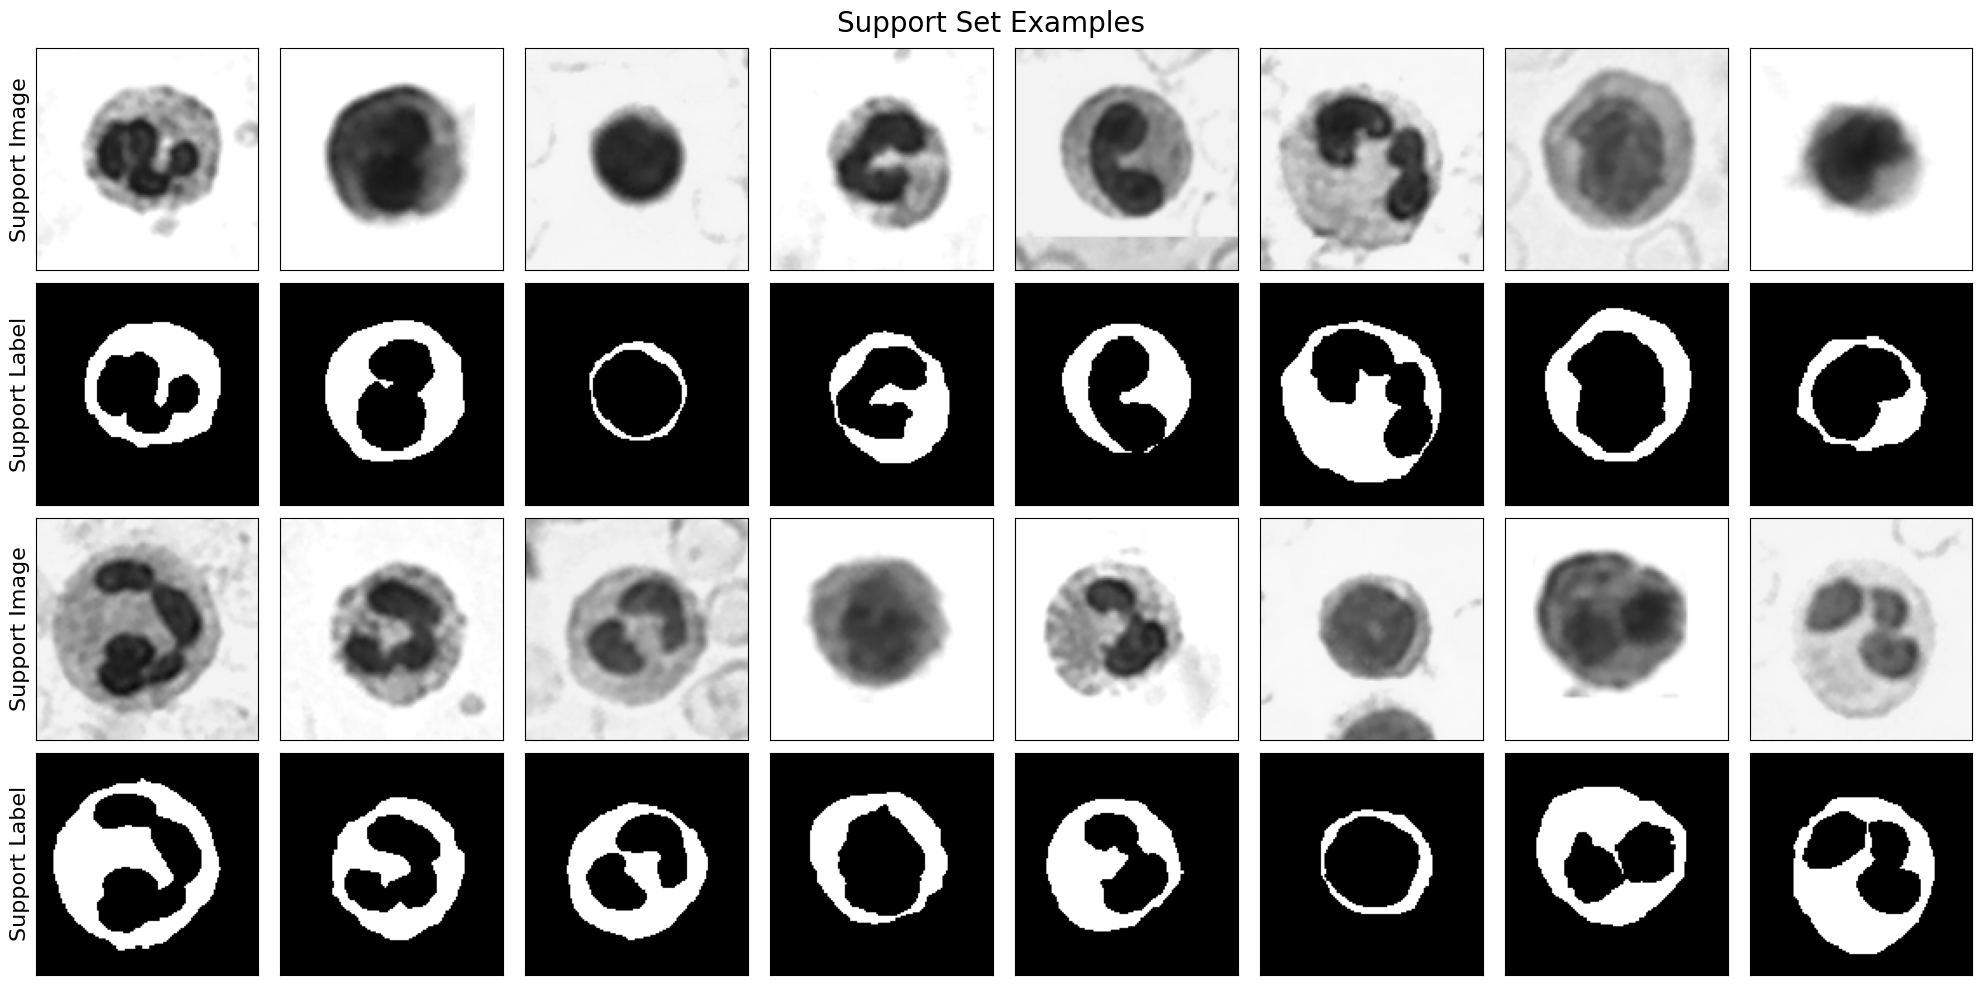

In [6]:
n_viz = 16
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, 8, title='Support Set Examples')

Now, we perform inference on the test set and visualize the images, the predictions

In [7]:
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()

In [8]:
@torch.no_grad()
def inference(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits        
    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)
    score = dice_score(hard_pred, label)
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': score}

  0%|          | 0/10 [00:00<?, ?it/s]

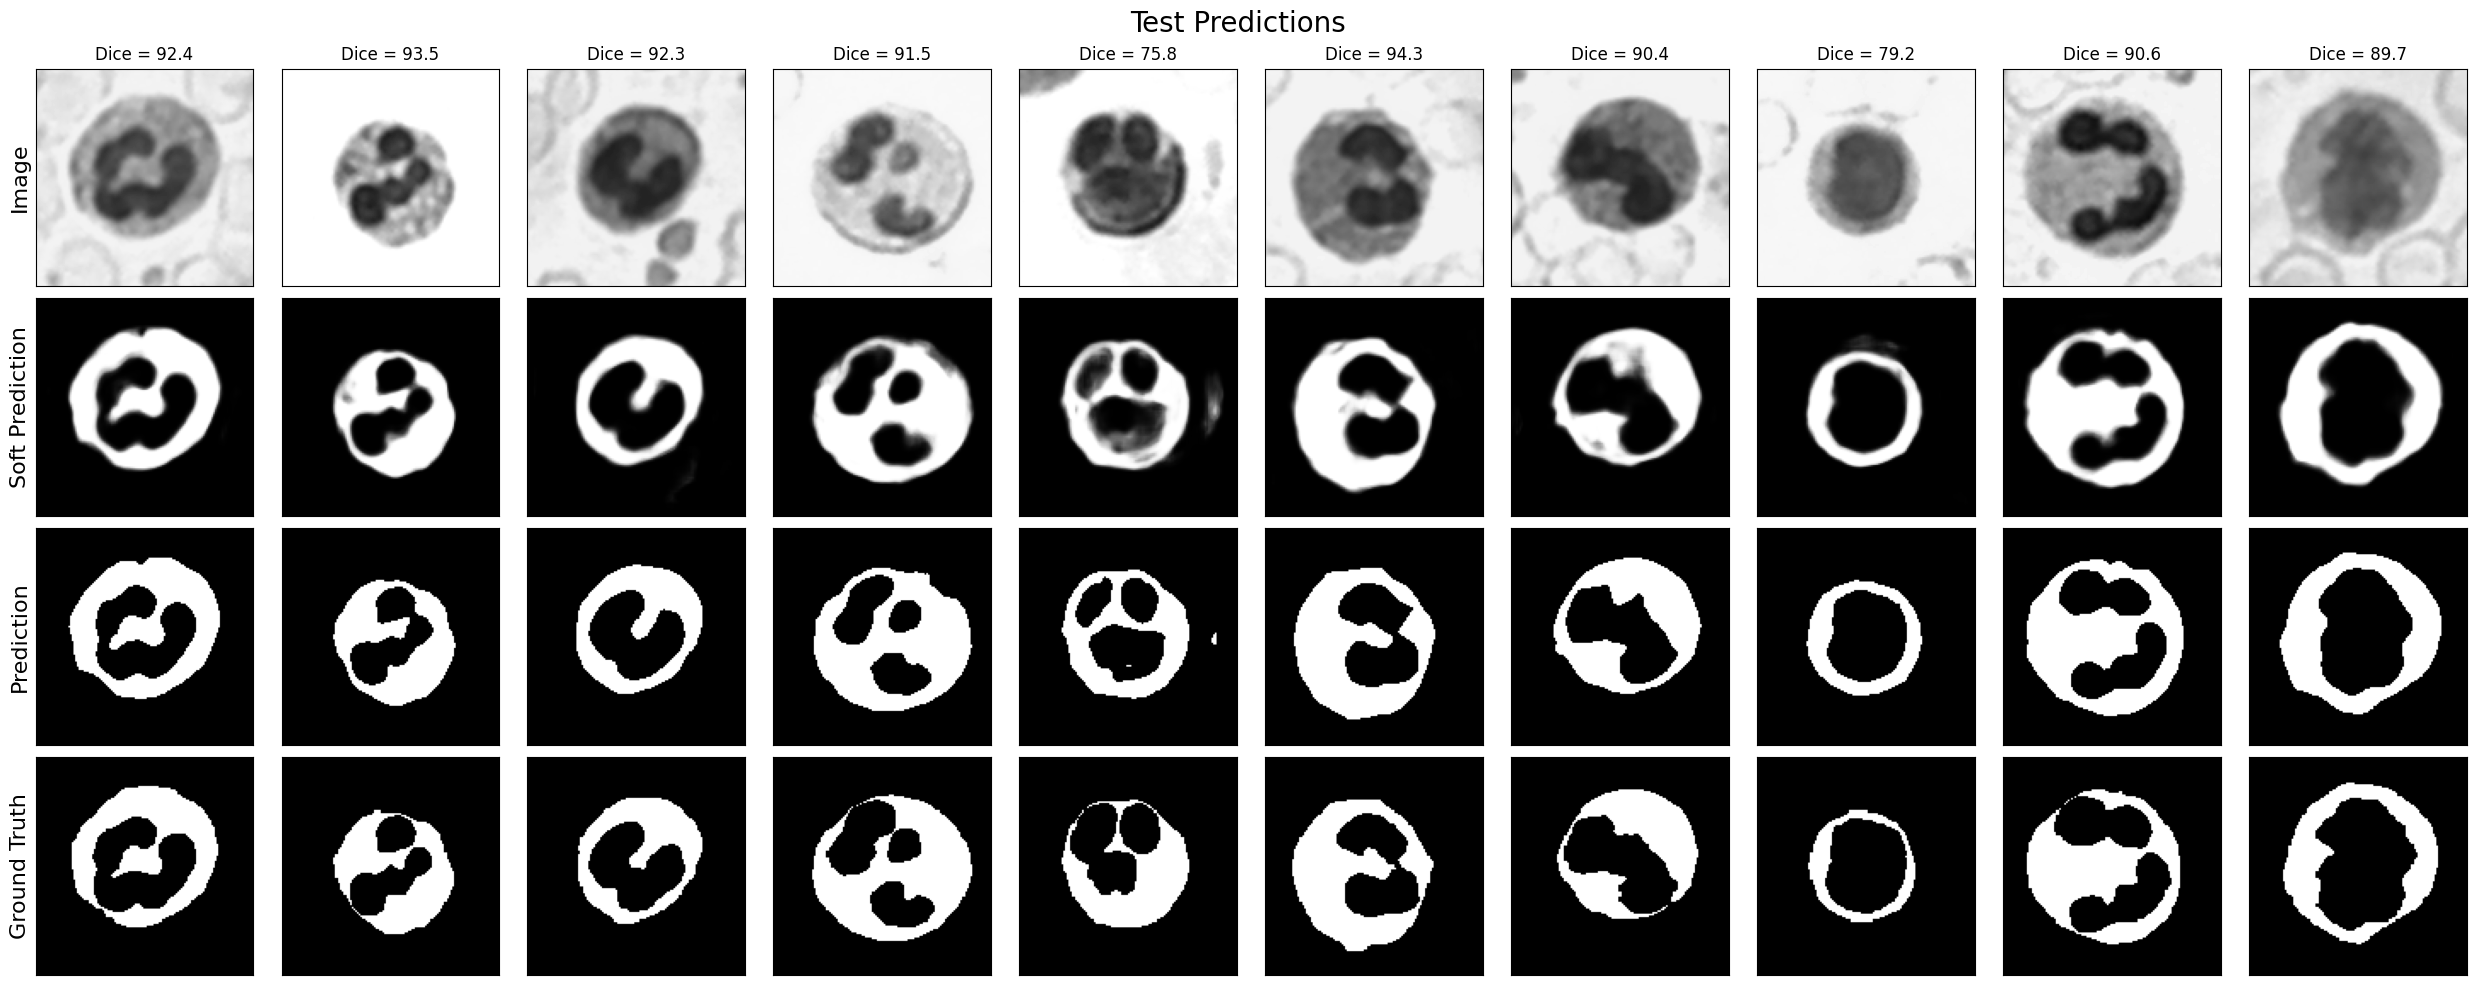

In [9]:
from collections import defaultdict

n_predictions = 10

results = defaultdict(list)
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)
    
scores = results.pop('score')    
visualize_tensors(results, col_names=[f'Dice = {100*s:.1f}' for s in scores], title='Test Predictions', col_wrap=n_predictions)

---

## 3. UniverSeg Flexibility

We show how:

1. Changing the support labels changes the segmentation task
2. How transforming the images leads to the similar predictions

In [10]:
from example_data.wbc import WBCDataset

d_support = WBCDataset('JTSC', split='support', label='nucleus')
d_test = WBCDataset('JTSC', split='test', label='nucleus')

n_support = 64

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

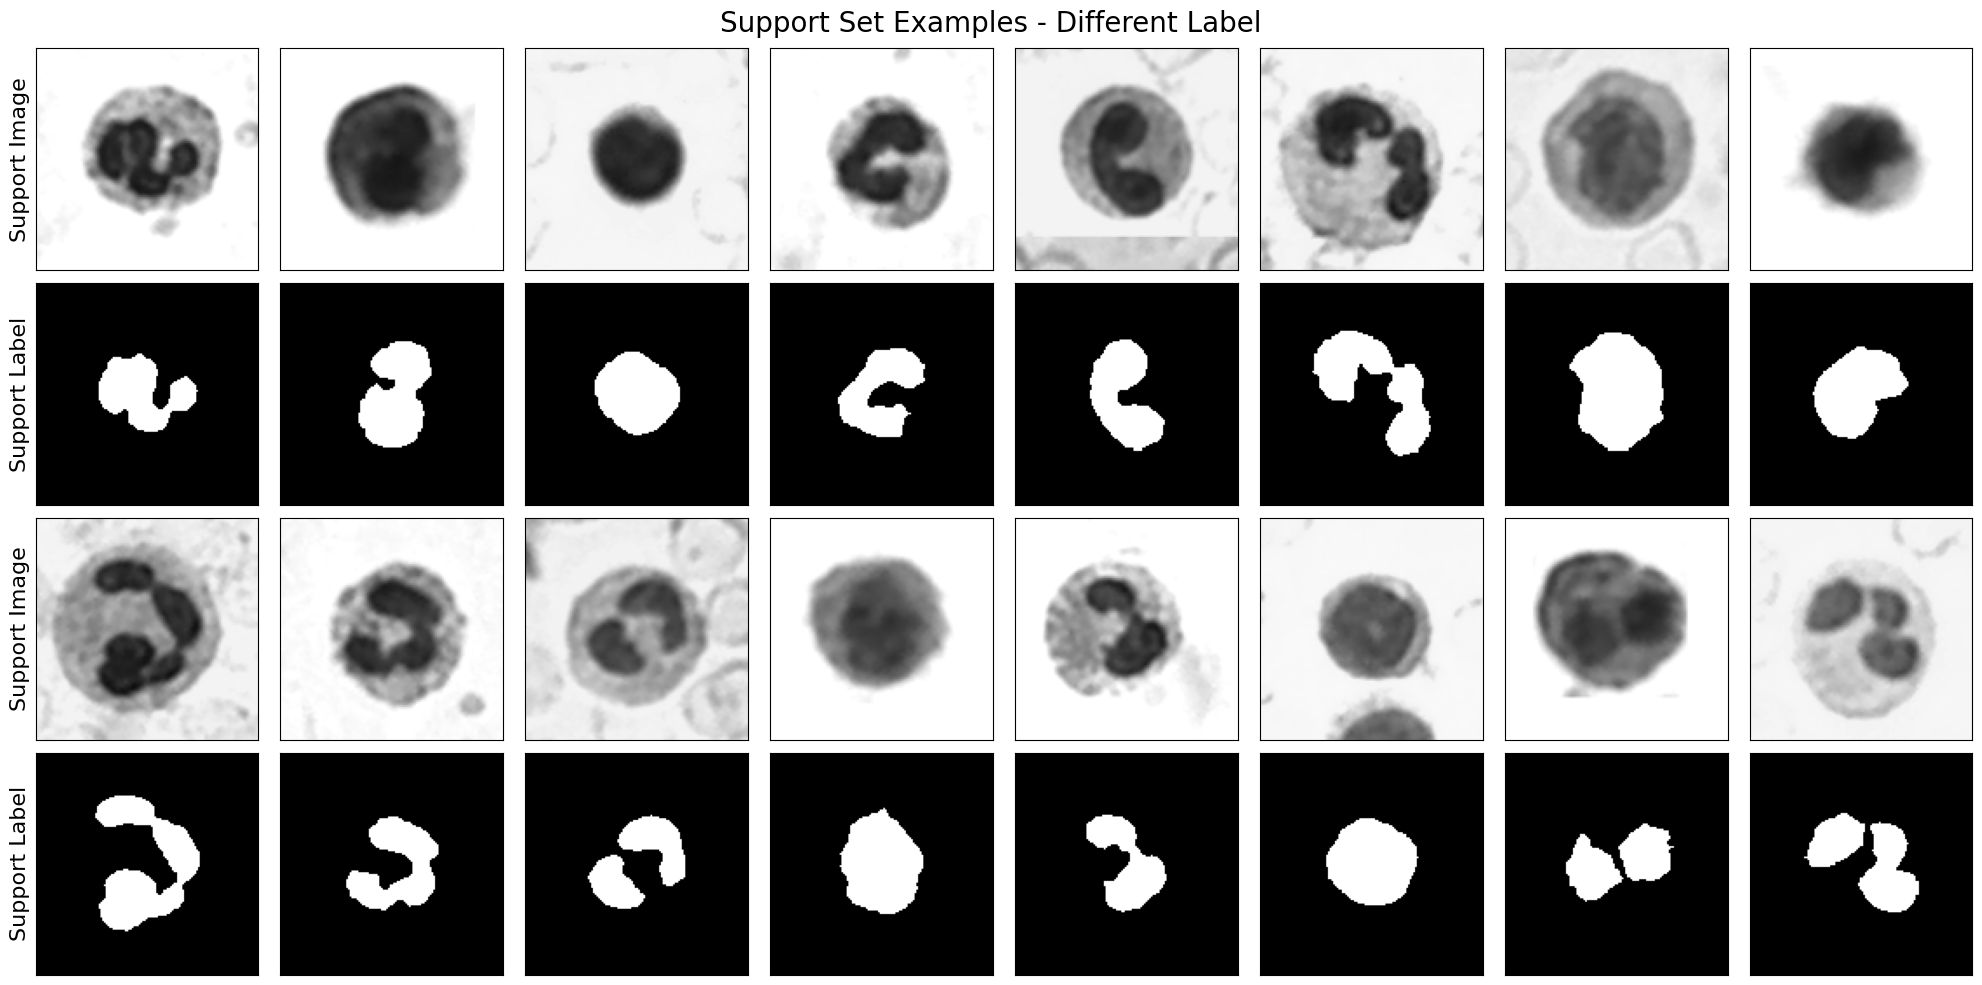

In [11]:
n_viz = 16
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, 8, title='Support Set Examples - Different Label')

  0%|          | 0/10 [00:00<?, ?it/s]

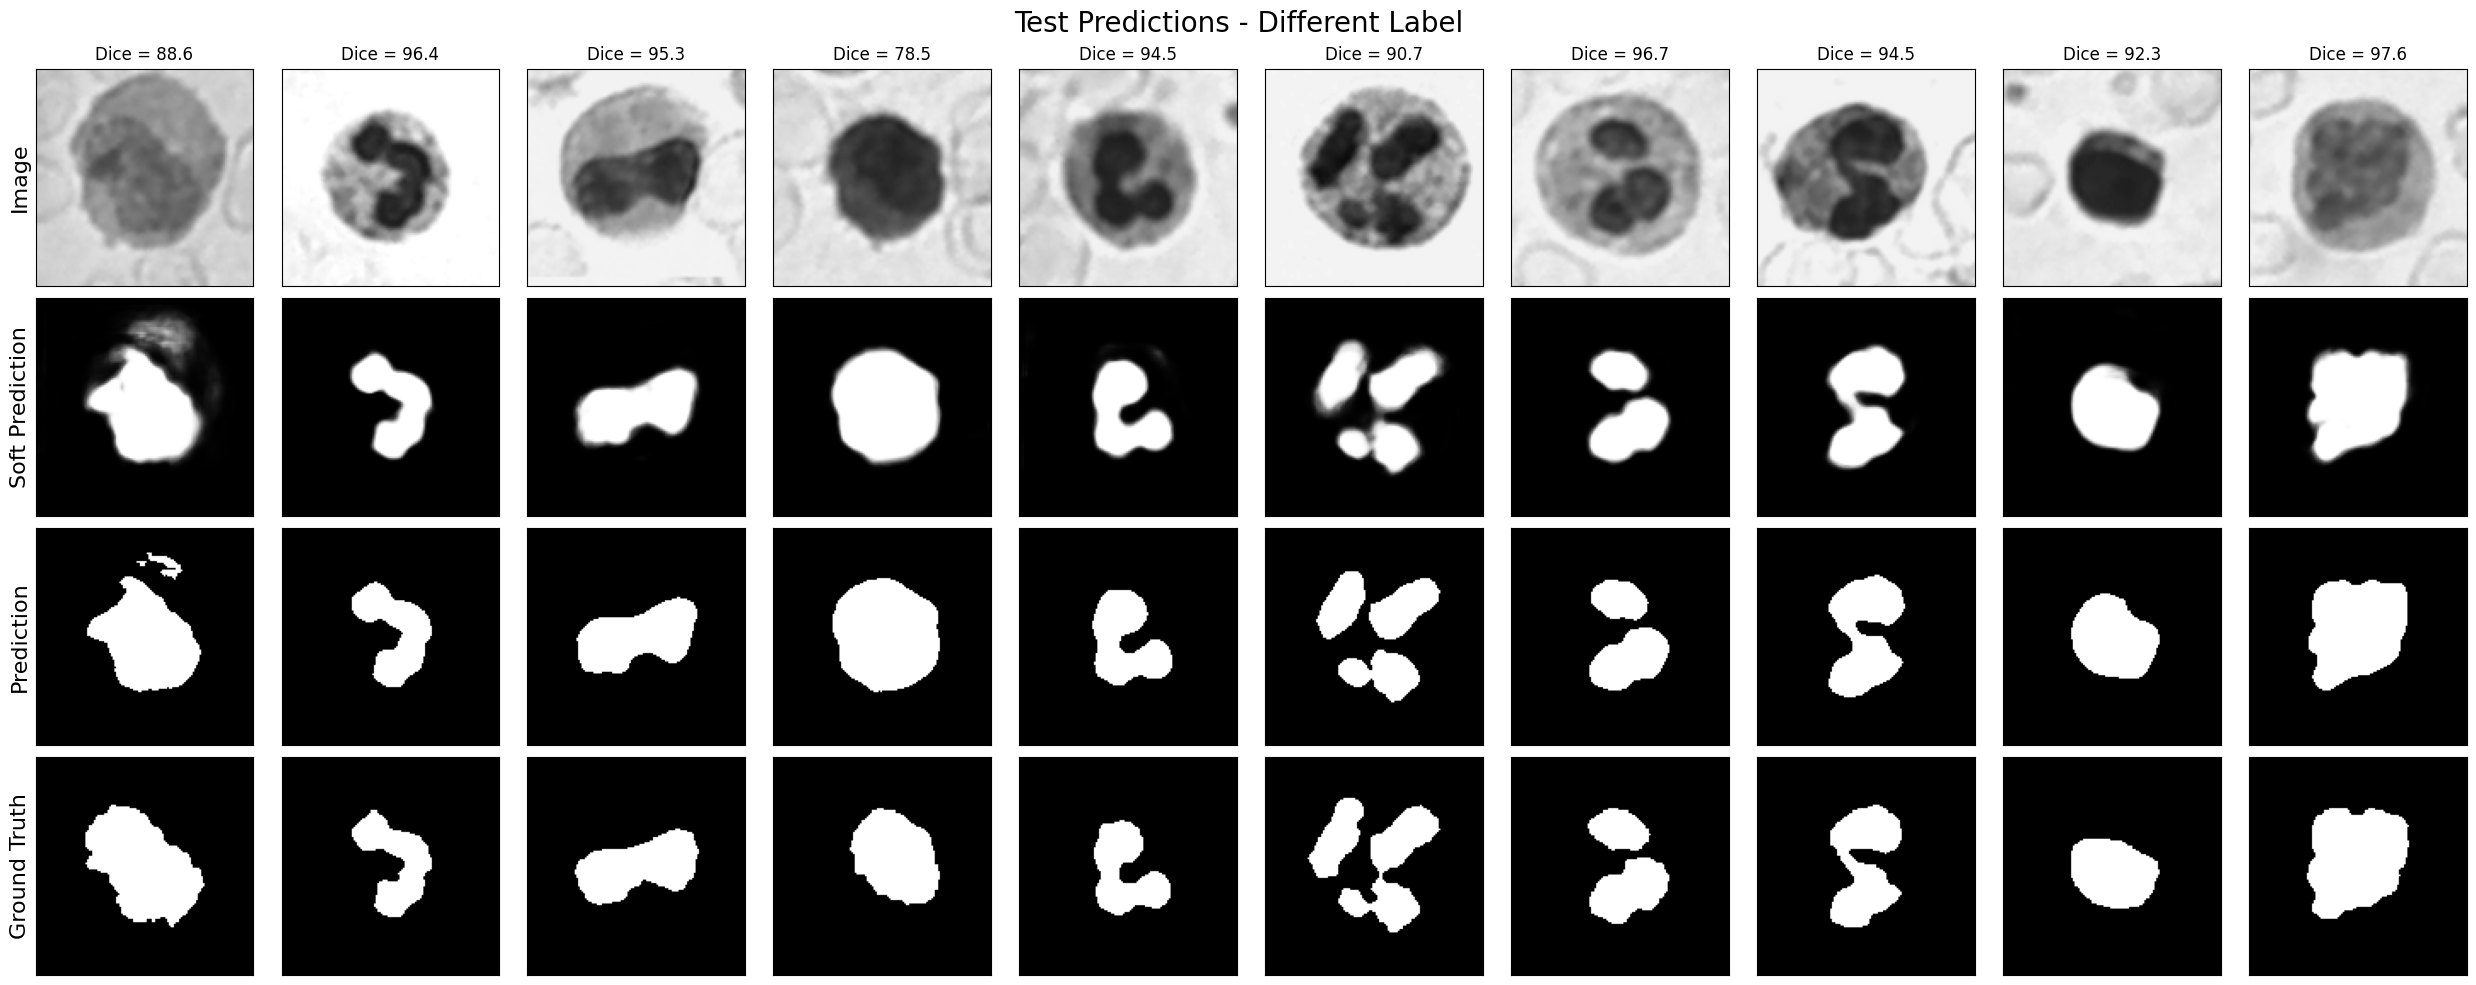

In [12]:
from collections import defaultdict

n_predictions = 10

results = defaultdict(list)
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)
    
scores = results.pop('score')    
visualize_tensors(results, col_names=[f'Dice = {100*s:.1f}' for s in scores], title='Test Predictions - Different Label', col_wrap=n_predictions)



Now, we flip the images but keep the labels

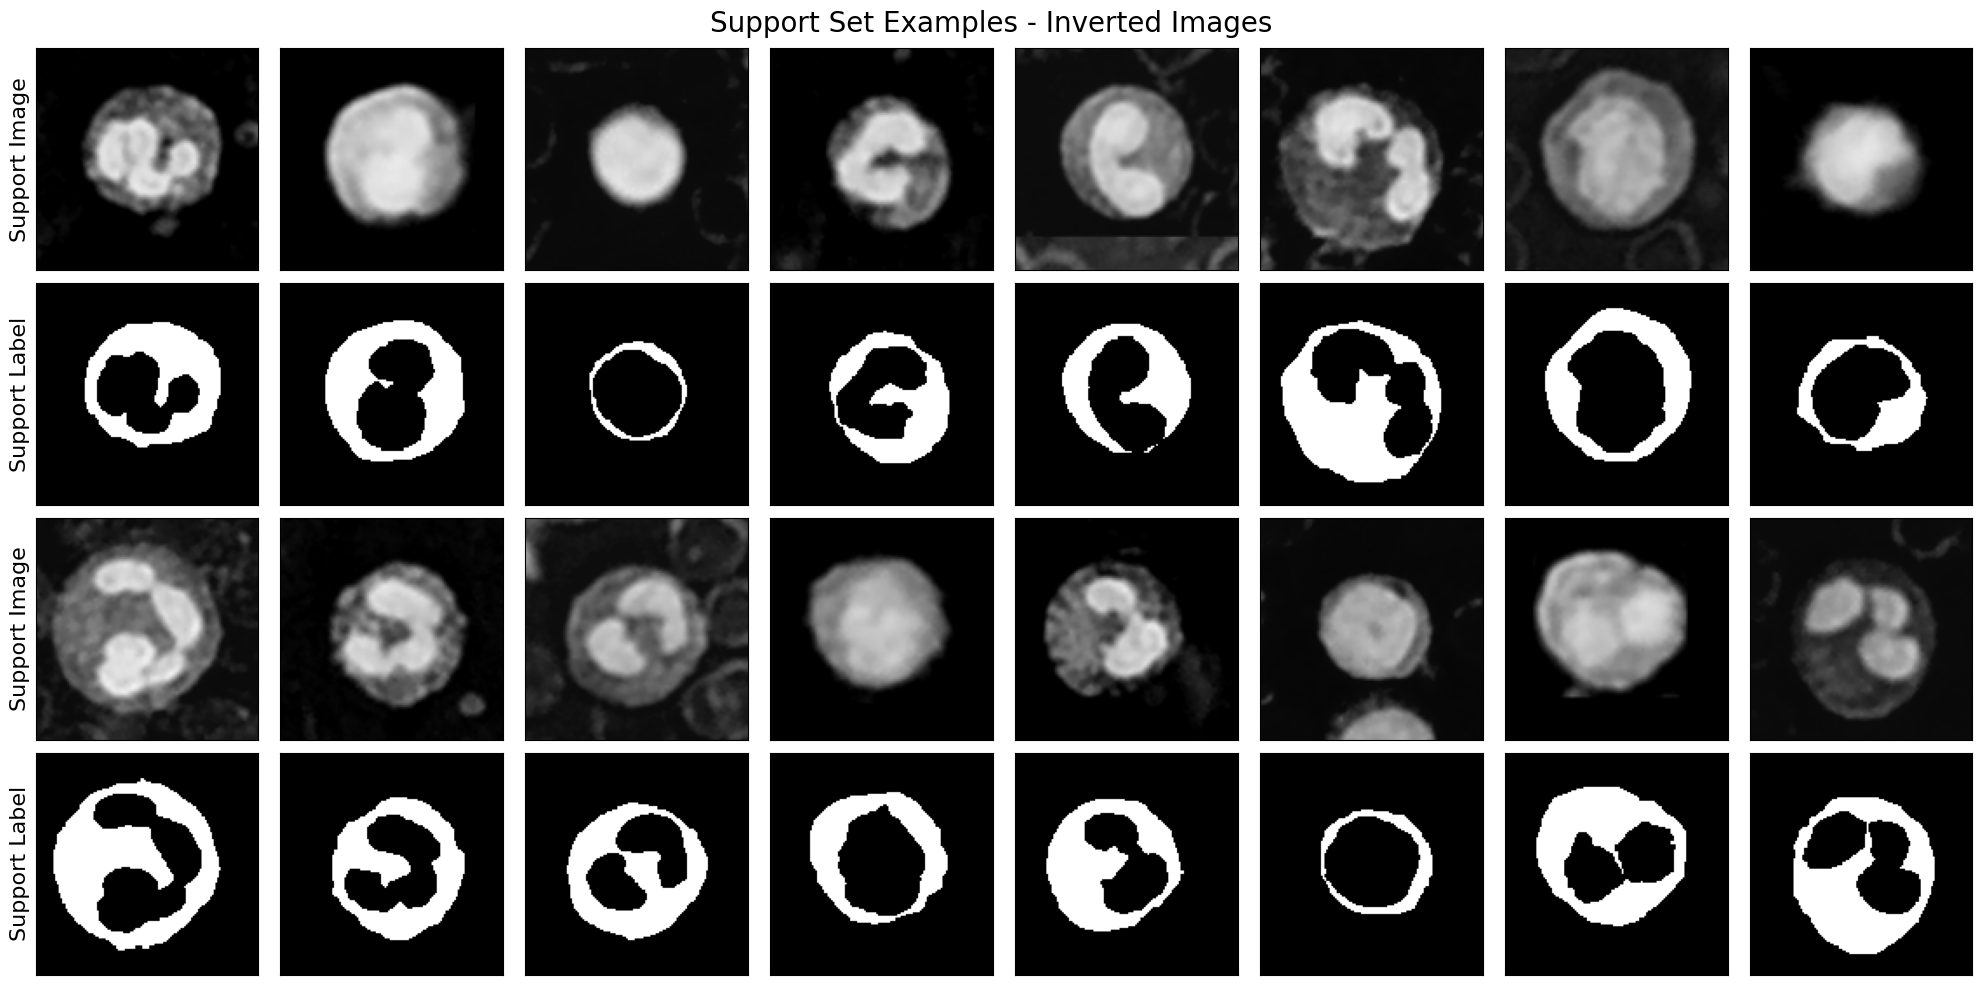

In [13]:
from example_data.wbc import WBCDataset

d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
d_test = WBCDataset('JTSC', split='test', label='cytoplasm')

n_support = 64

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

support_images = 1 - support_images ## FLIP IMAGES

n_viz = 16
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, 8,  title='Support Set Examples - Inverted Images')

  0%|          | 0/10 [00:00<?, ?it/s]

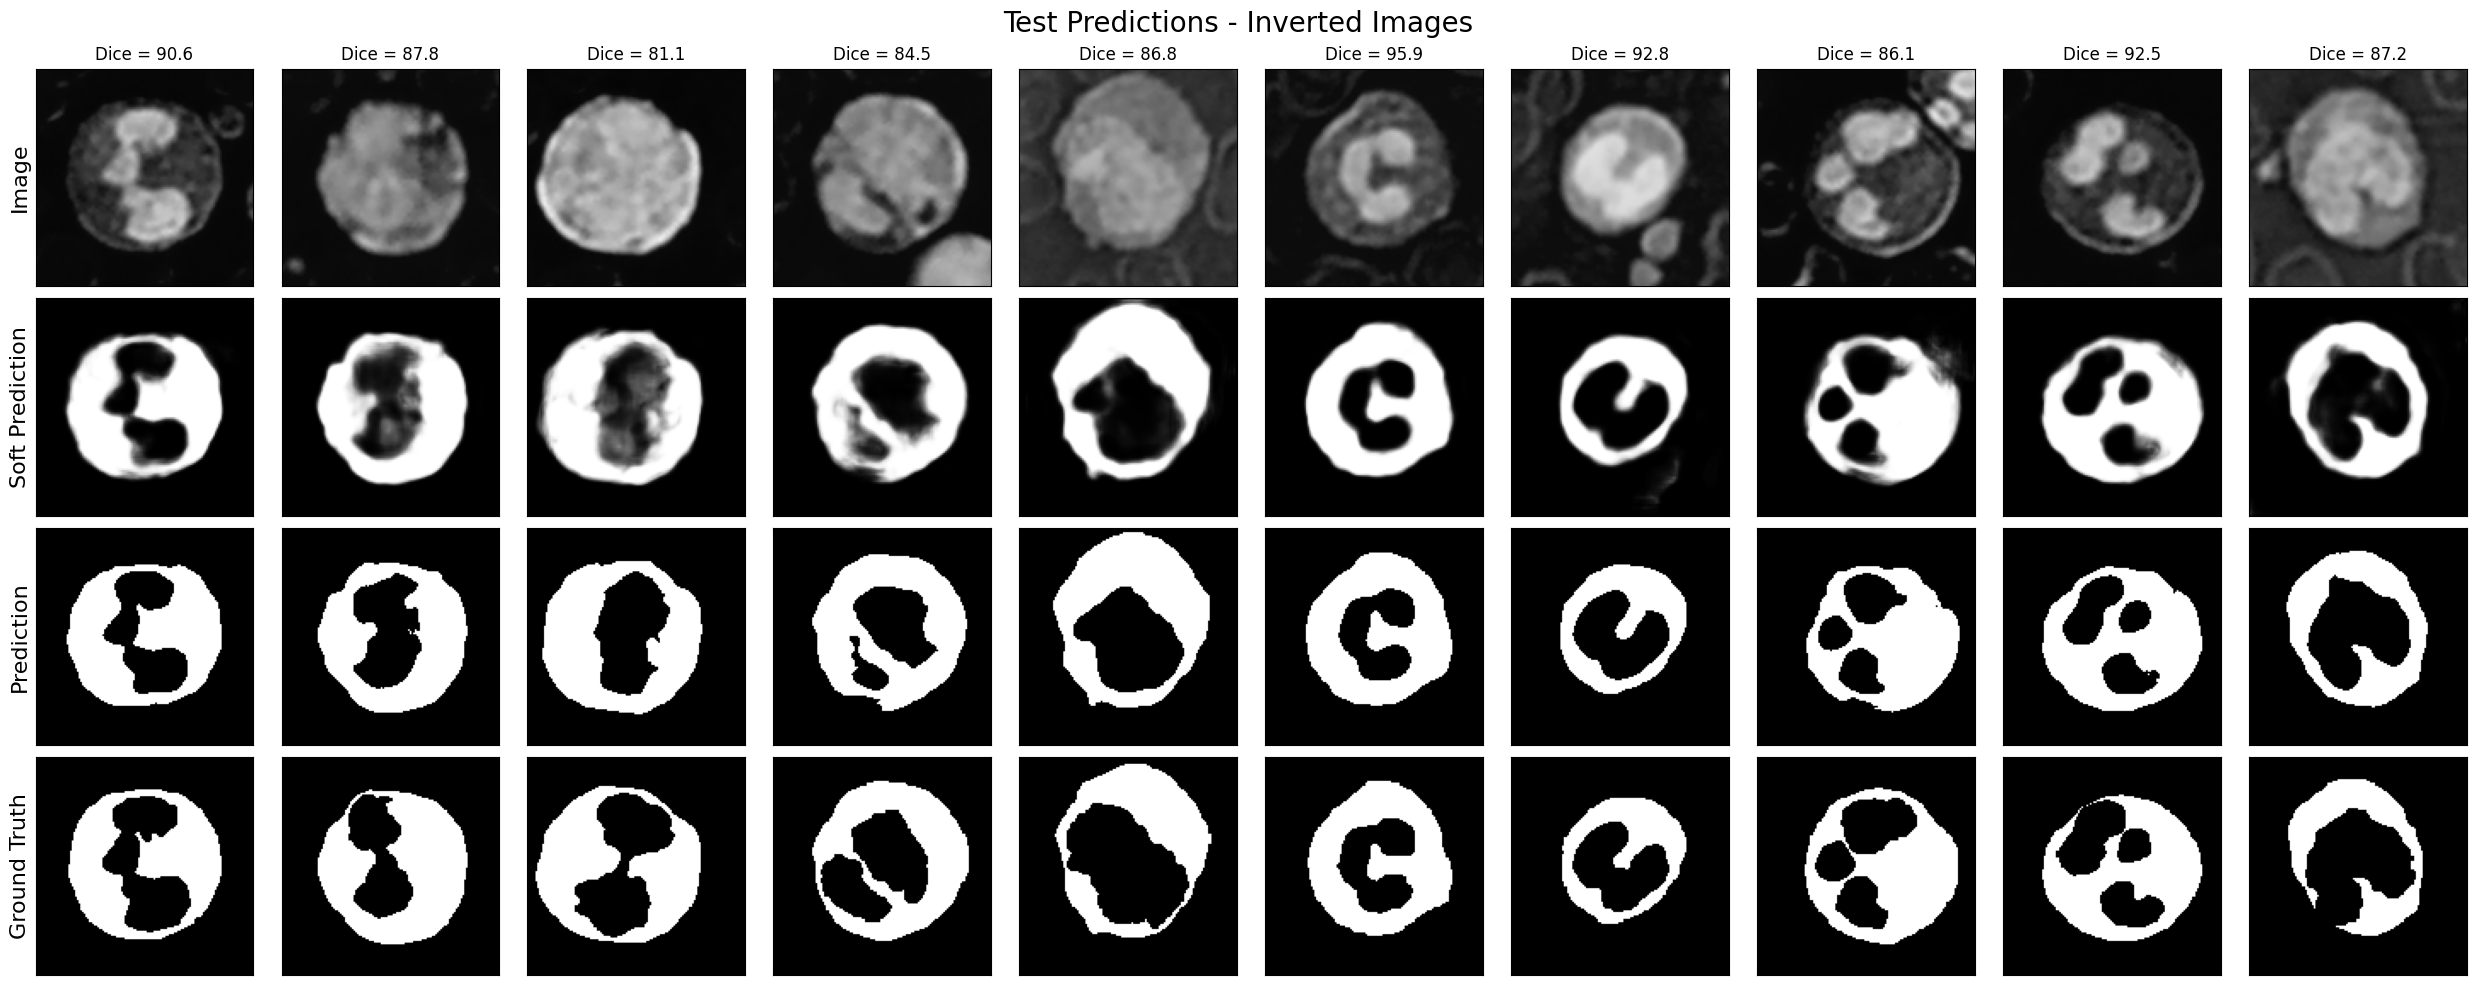

In [14]:
from collections import defaultdict

n_predictions = 10

results = defaultdict(list)
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference(model, 1-image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)
    
scores = results.pop('score')    
visualize_tensors(results, col_names=[f'Dice = {100*s:.1f}' for s in scores], title='Test Predictions - Inverted Images', col_wrap=n_predictions)

---


## 4. Effect of the Support Set Size

We study how changing the number of support examples affects the prediction, observing how increasing the support set size leads to improved results

In [15]:
from example_data.wbc import WBCDataset

d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
d_test = WBCDataset('JTSC', split='test', label='cytoplasm')

n_support = 64

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

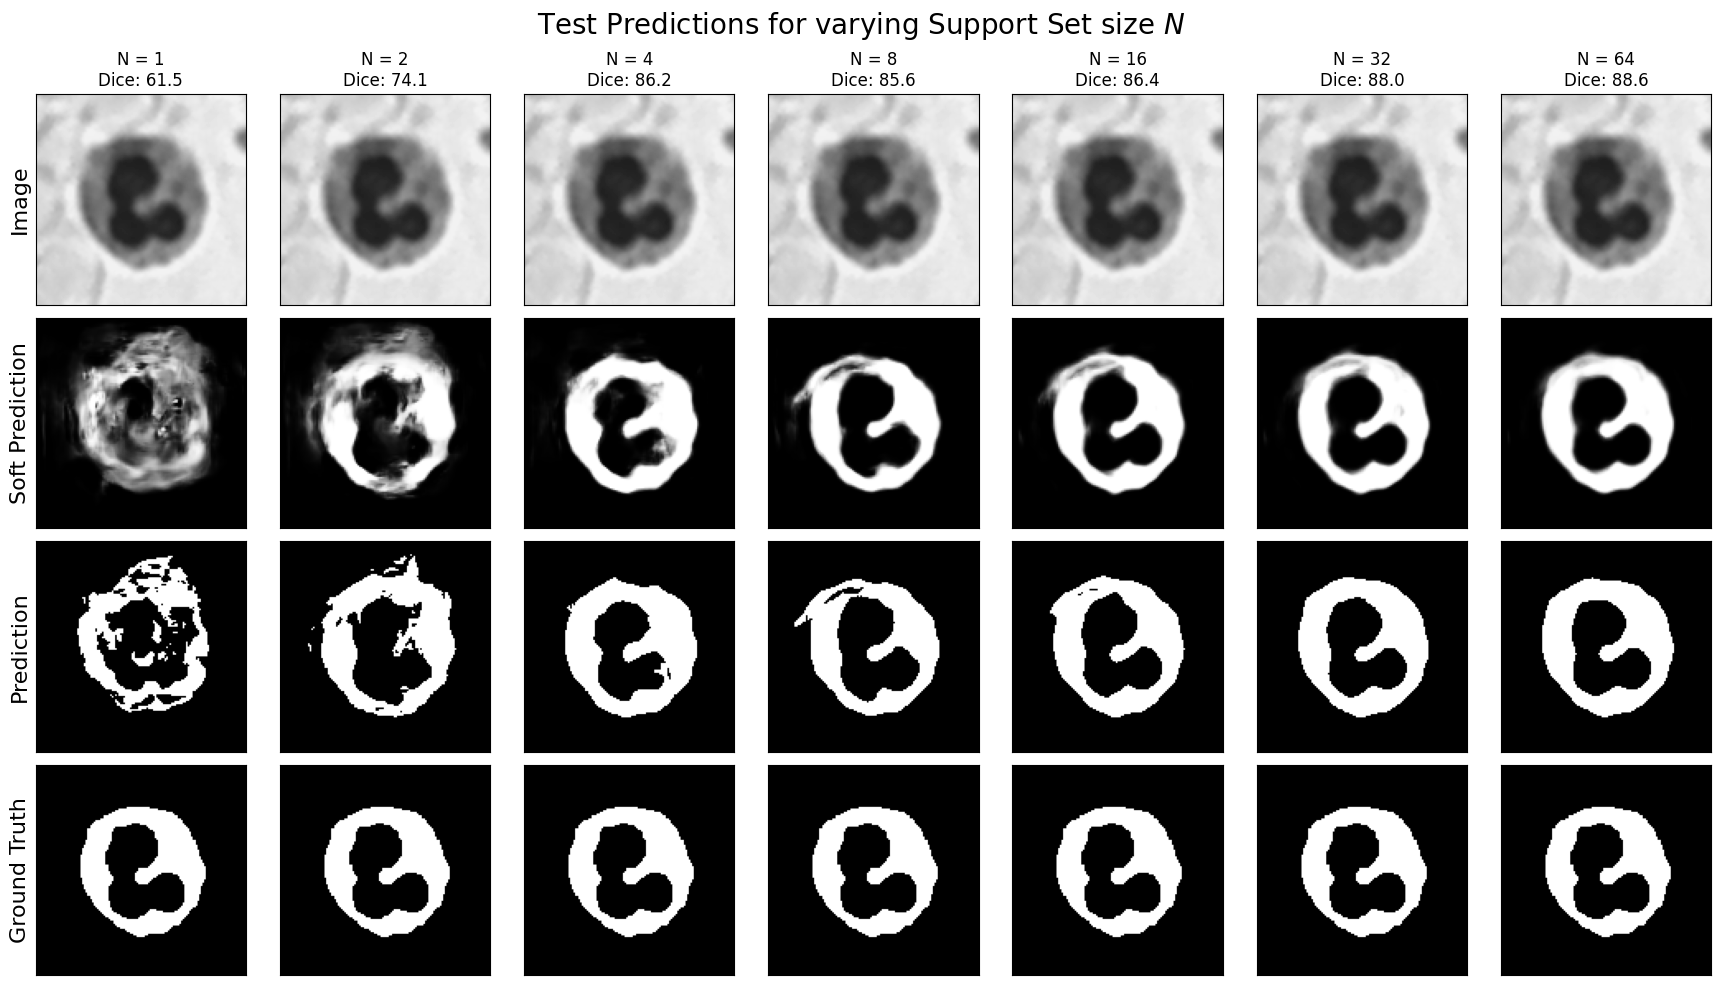

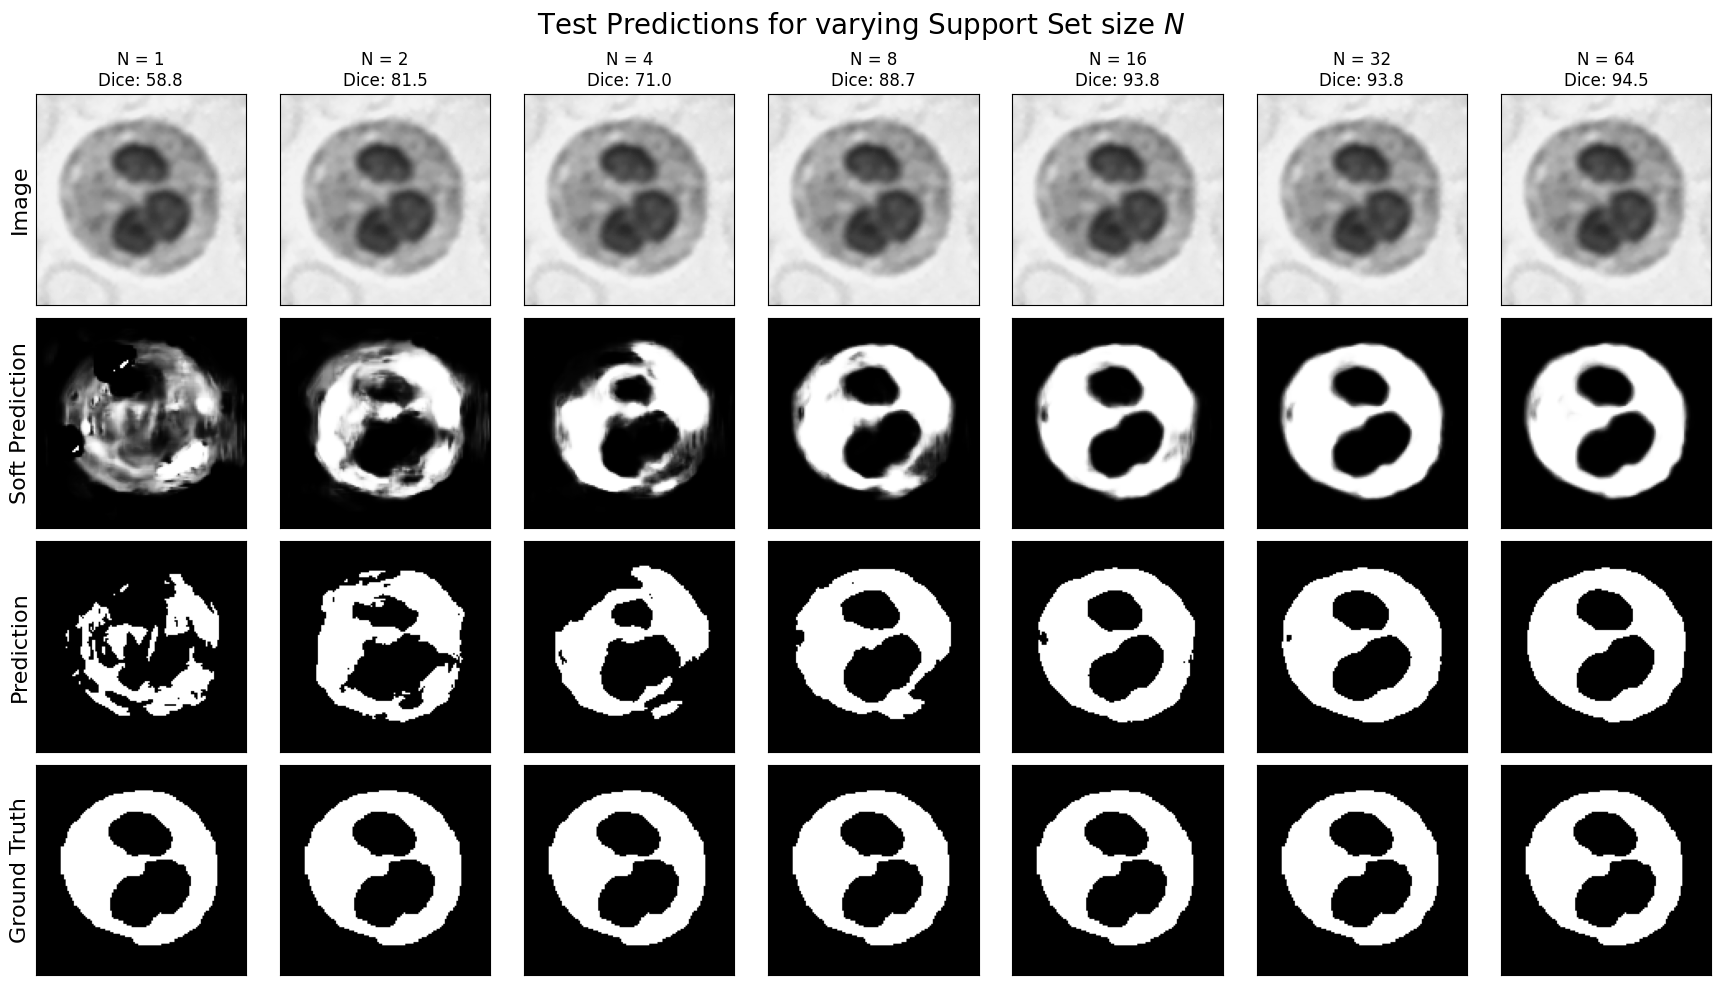

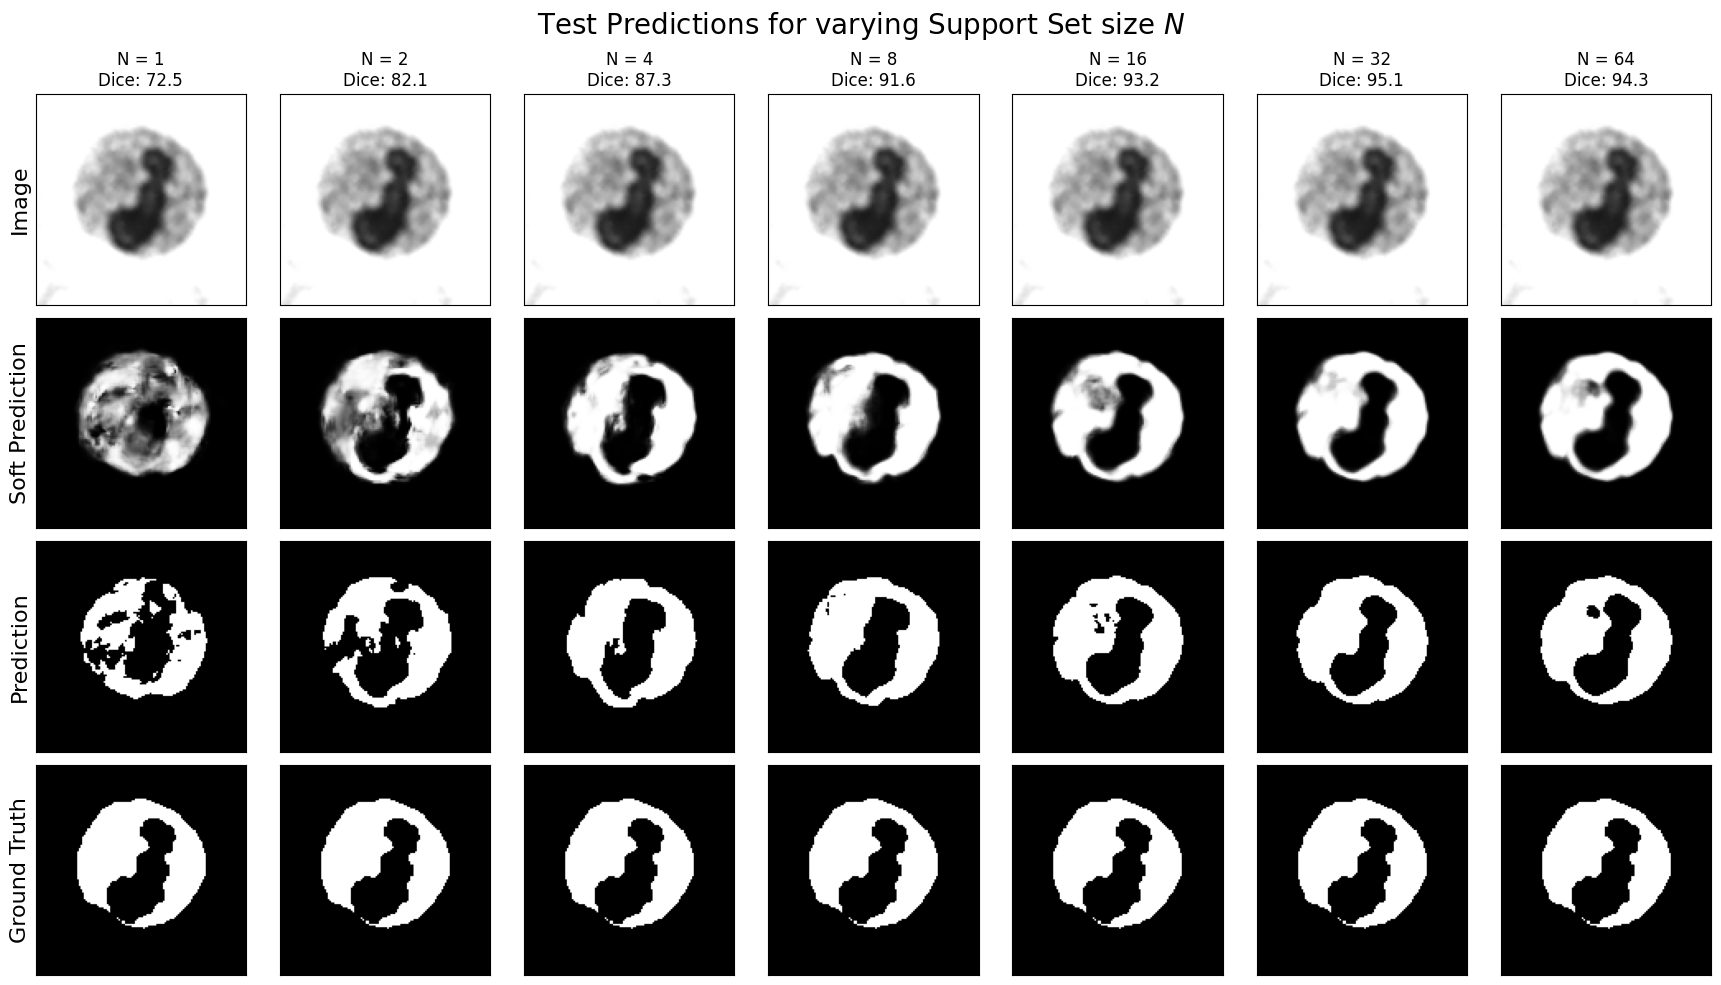

In [16]:
from collections import defaultdict

n_predictions = 3


idxs = np.random.permutation(len(d_test))[:n_predictions]

support_set_sizes = [1,2,4,8,16,32,64]

for i in idxs:
    results = defaultdict(list)
    for N in support_set_sizes:
        image, label = d_test[i]
        vals = inference(model, image, label, support_images[:N], support_labels[:N])
        for k, v in vals.items():
            results[k].append(v)
    
    scores = results.pop('score')    
    col_names = [f'N = {N}' for N in support_set_sizes]
    col_names = [col+f'\nDice: {100*score:.1f}' for col, score in zip(col_names, scores)]
    visualize_tensors(results, col_names=col_names, title='Test Predictions for varying Support Set size $N$', col_wrap=len(support_set_sizes))

---

## 5. Multi-label Predictions

While UniverSeg is a binary segmentation model, we can perform multilabel prediction by running the model with support sets of each label independently

In [17]:
import einops as E

In [18]:
from example_data.wbc import WBCDataset


d_support = WBCDataset('JTSC', split='support', label=None)
d_test = WBCDataset('JTSC', split='test', label=None)

n_support = 64

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

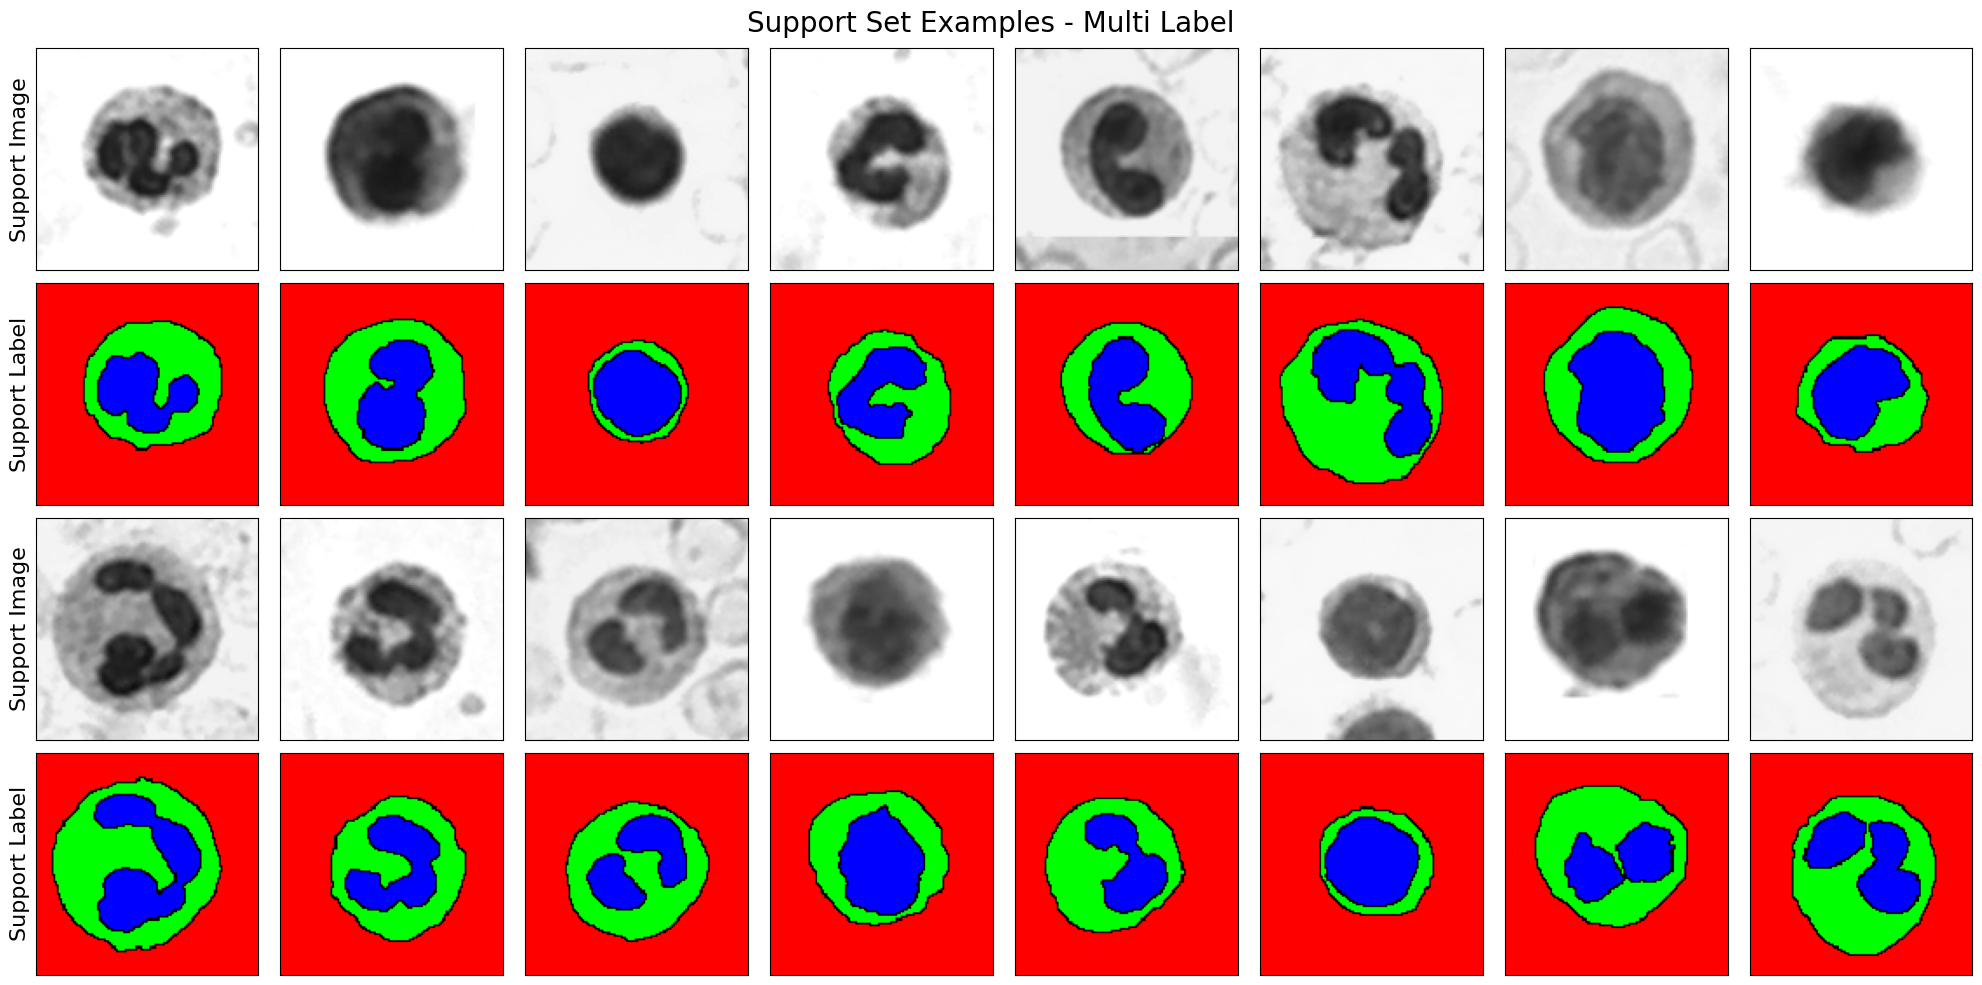

In [19]:
n_viz = 16
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, 8, title='Support Set Examples - Multi Label')

In [20]:
import torch.nn.functional as F
@torch.no_grad()
def inference_multi(model, image, label_onehot, support_images, support_labels_onehot):
    n_labels = label_onehot.shape[0]
    image, label_onehot = image.to(device), label_onehot.to(device)
    all_logits = []
    soft_pred_onehot = []
    for k in range(n_labels):
        label = label_onehot[k:k+1]
        support_labels = support_labels_onehot[:,k:k+1]
        logits = model(
            image[None],
            support_images[None],
            support_labels[None]
        )[0] # outputs are logits        
        soft_pred = torch.sigmoid(logits)
        soft_pred_onehot.append(soft_pred)
    soft_pred_onehot = torch.stack(soft_pred_onehot)
    hard_pred = F.softmax(10*soft_pred_onehot,dim=0)
    scores = []
    for k in range(n_labels):
        score = dice_score(hard_pred[k], label_onehot[k])
        scores.append(score)
    return {'Image': image,
            'Soft Prediction': soft_pred_onehot,
            'Prediction': hard_pred,
            'Ground Truth': label_onehot,
            'score': np.mean(scores)}

  0%|          | 0/10 [00:00<?, ?it/s]

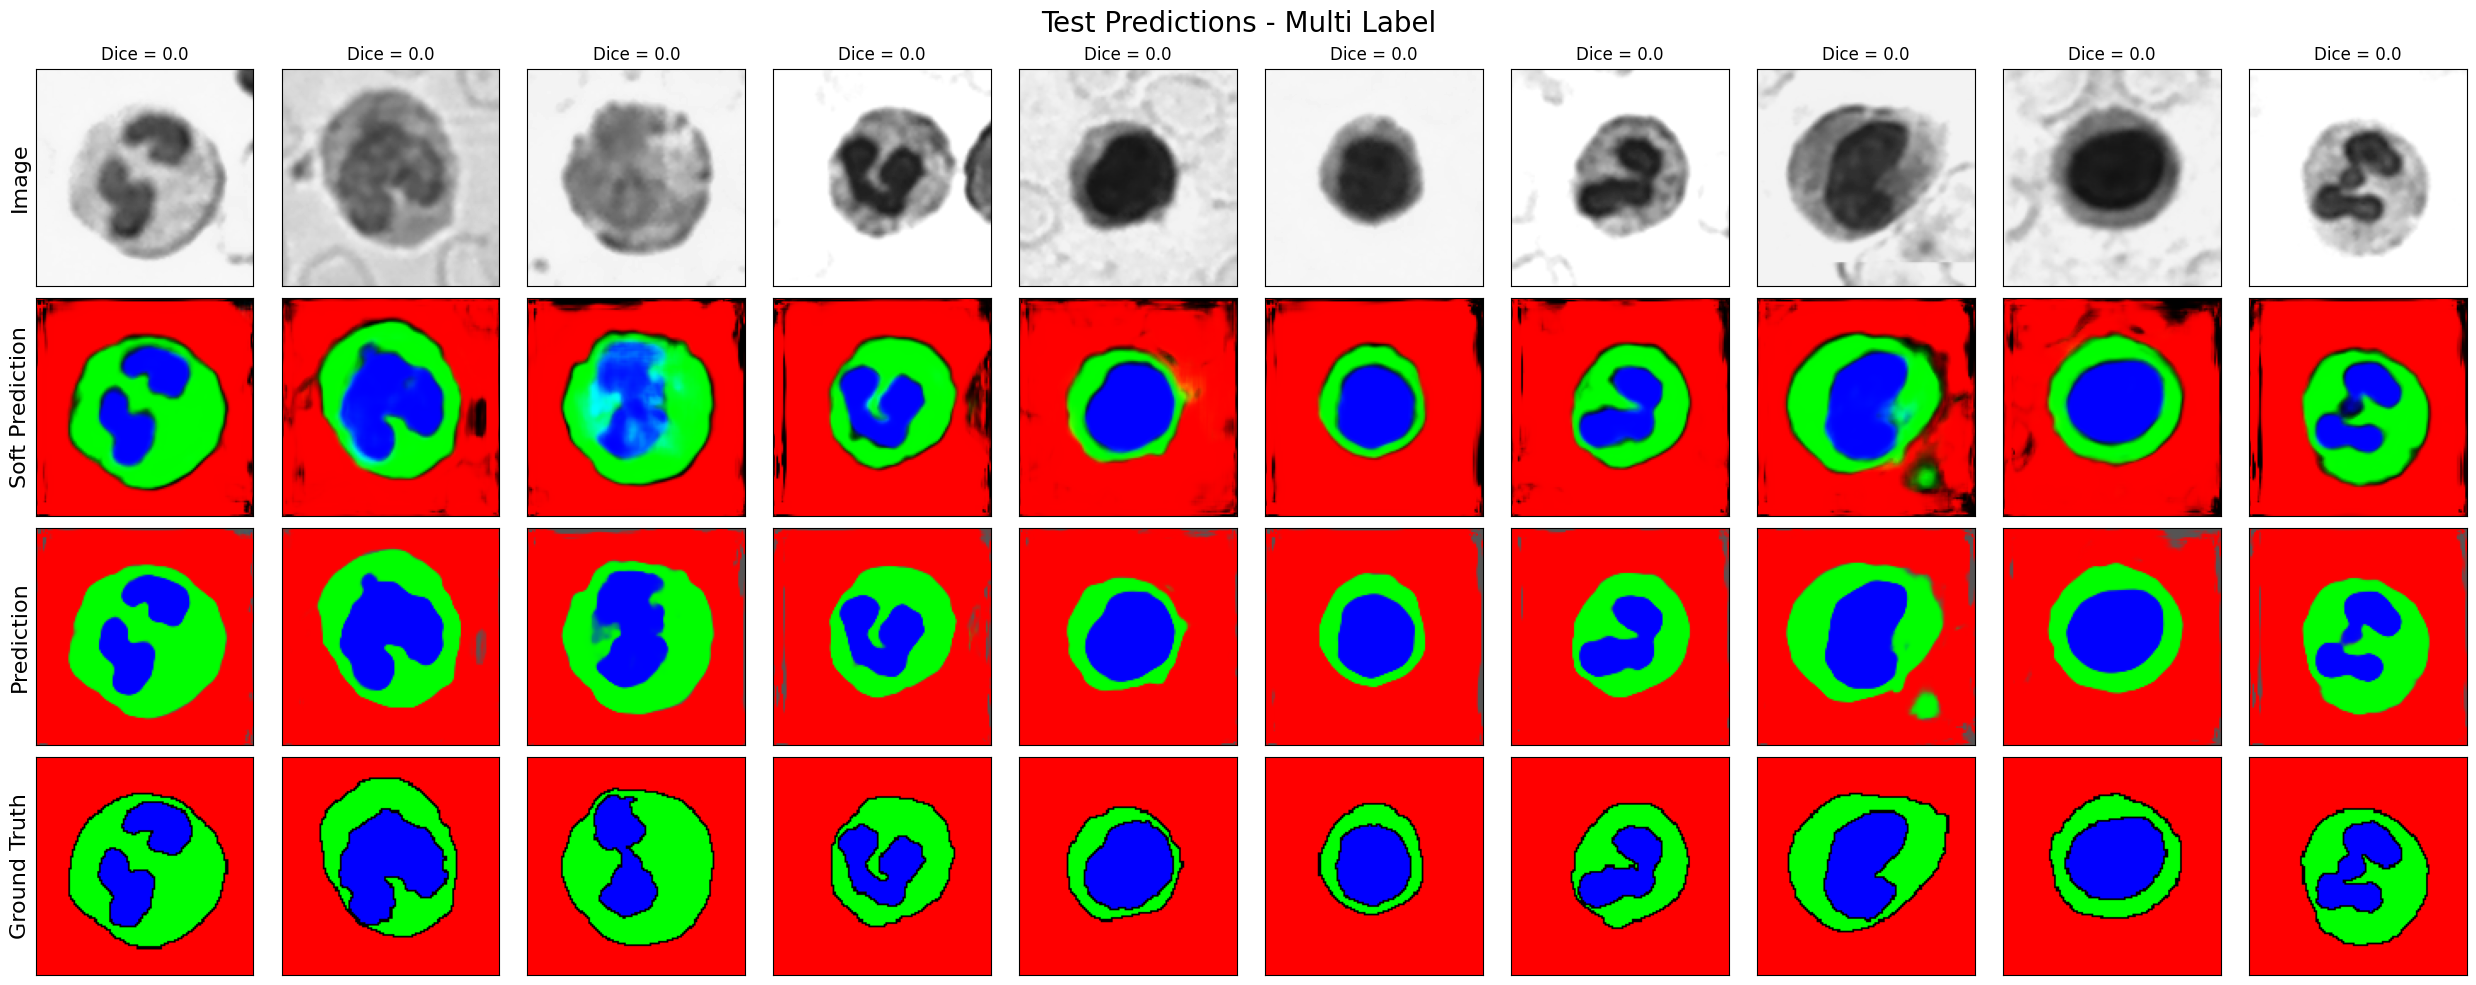

In [21]:
from collections import defaultdict

n_predictions = 10

results = defaultdict(list)
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference_multi(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)
    
scores = results.pop('score')    
visualize_tensors(results, col_names=[f'Dice = {100*s:.1f}' for s in scores], title='Test Predictions - Multi Label', col_wrap=n_predictions)

___


## 6. Ensembling Predictions

As different support sets result in different predictions, we show how ensembling predictions can lead to improved results

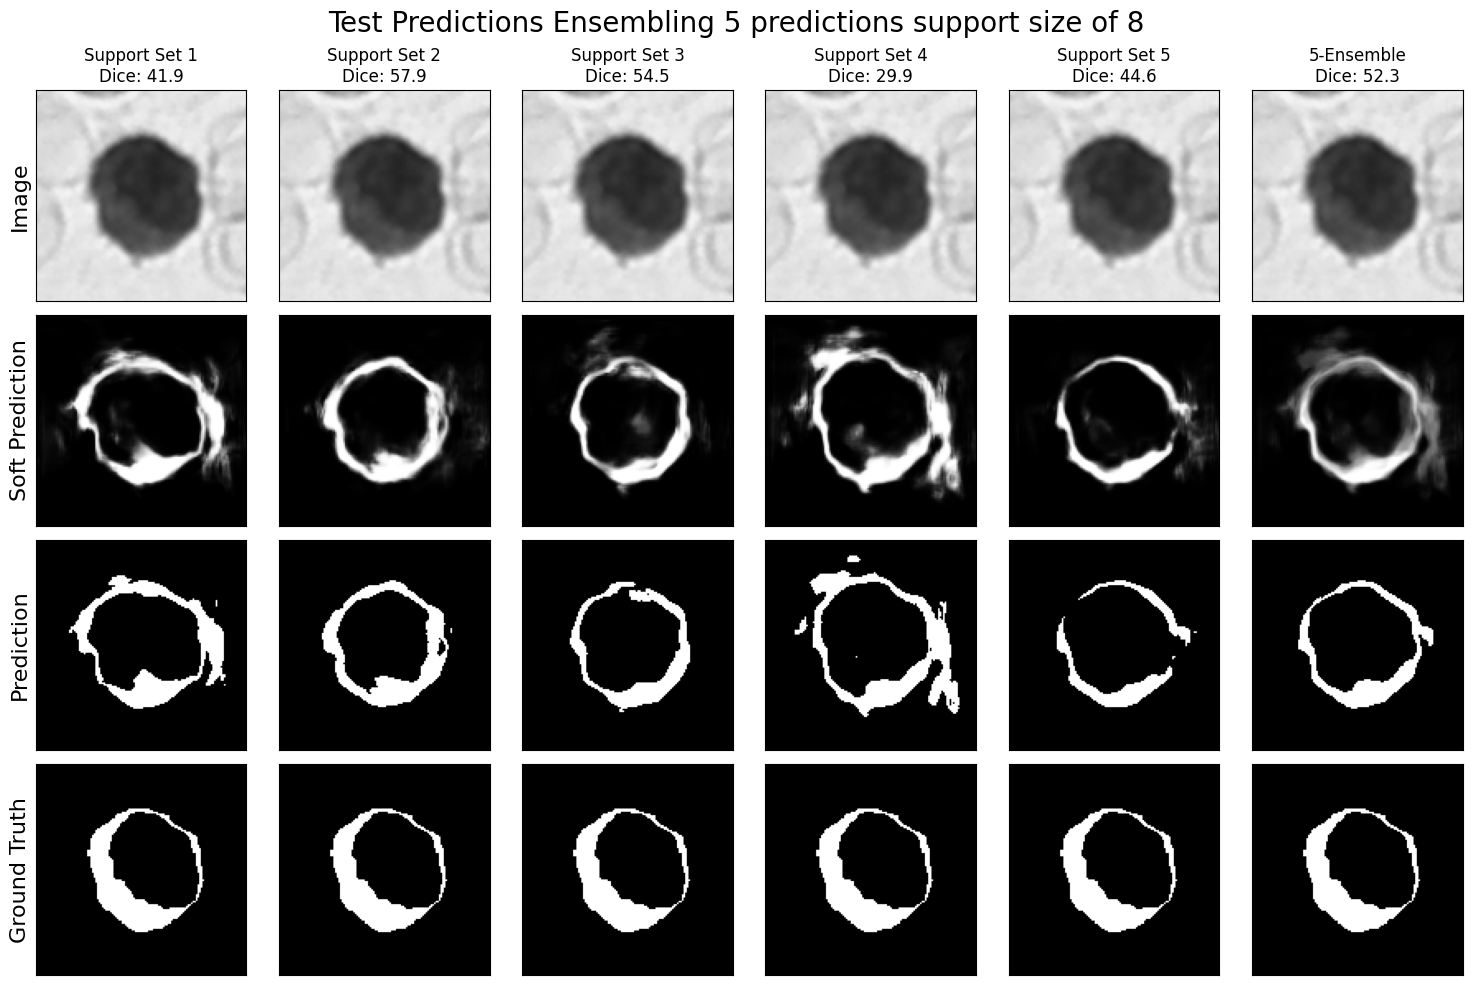

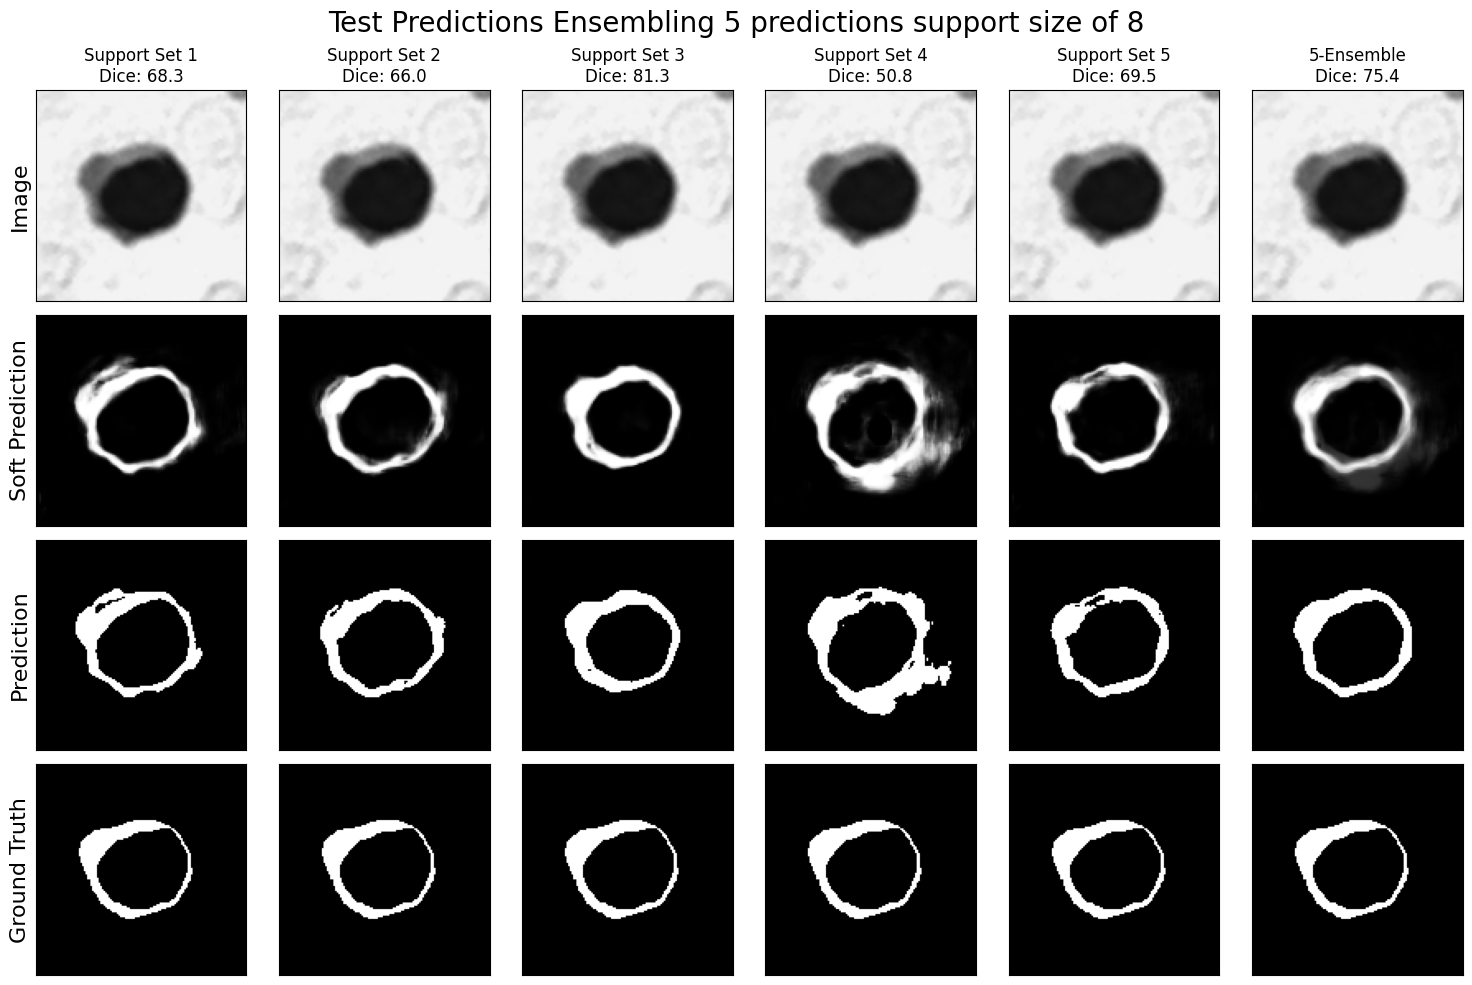

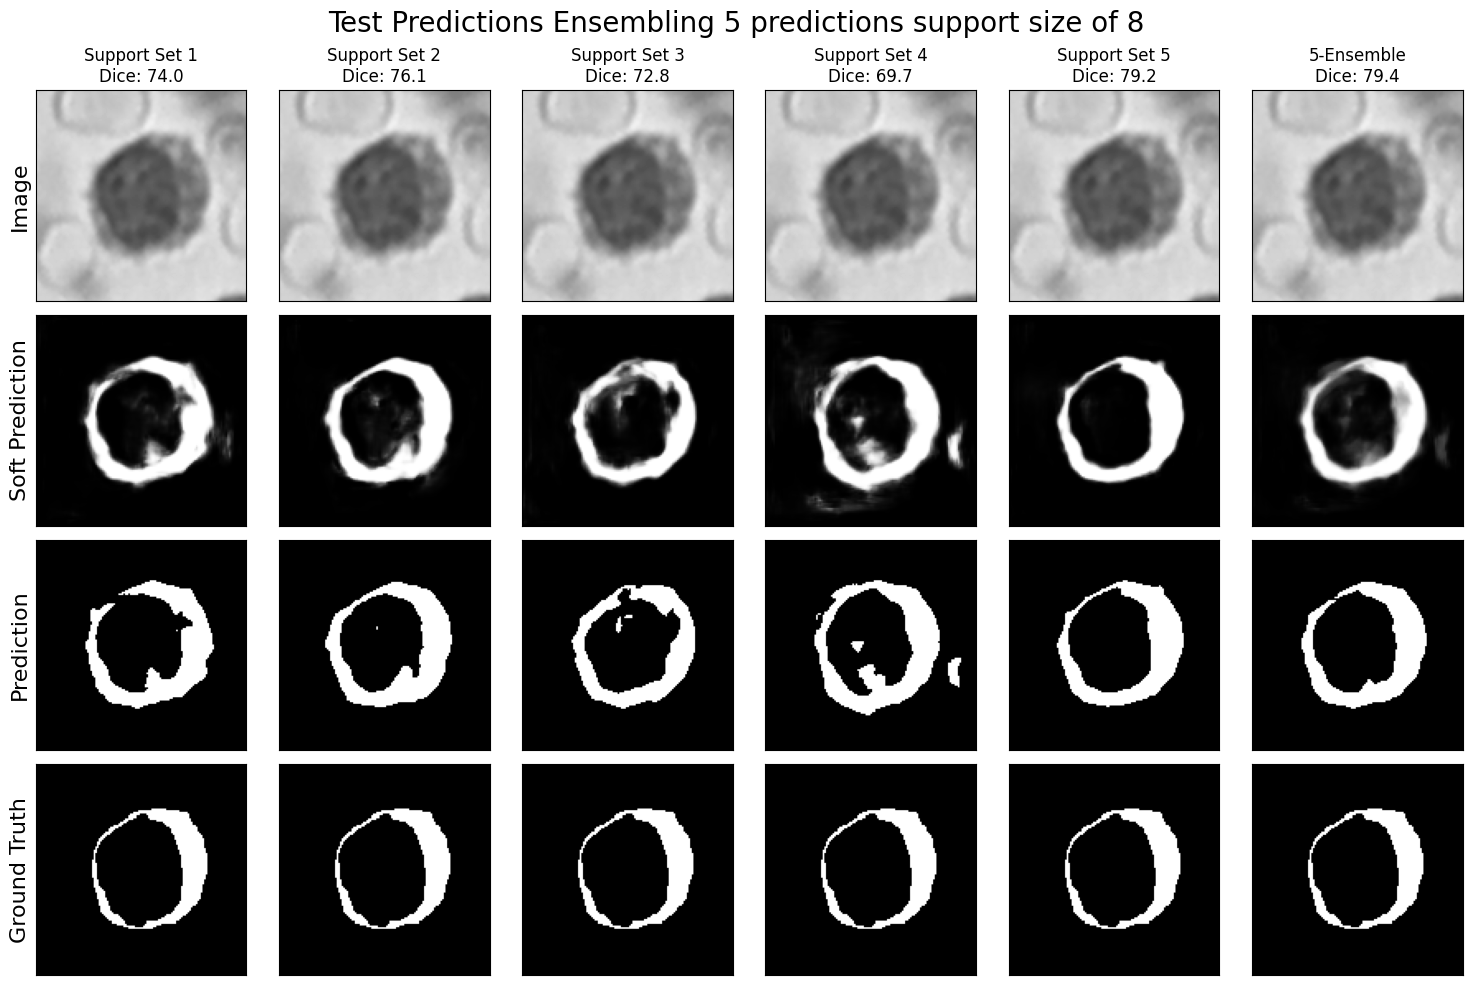

In [24]:
from collections import defaultdict

d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
d_test = WBCDataset('JTSC', split='test', label='cytoplasm')

n_predictions = 3
n_ensemble = 5
support_size = 8

idxs = np.random.permutation(len(d_test))[:n_predictions]

def sample_support(seed):
    rng = np.random.default_rng(seed)
    idxs = rng.integers(0,len(d_support), size=support_size)
    support_images, support_labels = zip(*[d_support[i] for i in idxs])
    support_images = torch.stack(support_images).to(device)
    support_labels = torch.stack(support_labels).to(device)
    return support_images, support_labels

seeds = range(n_ensemble)
supports = {
    seed: sample_support(seed)
    for seed in range(n_ensemble)
}

for i in idxs:
    results = defaultdict(list)
    for j in range(n_ensemble):
        
        support_images, support_labels = sample_support(j)
        
        image, label = d_test[i]
        vals = inference(model, image, label, support_images, support_labels)
        for k, v in vals.items():
            results[k].append(v)
    
    results['Image'].append(image)
    ensemble = torch.mean(torch.stack(results['Soft Prediction']), dim=0)
    results['Soft Prediction'].append(ensemble)
    results['Prediction'].append(ensemble.round())
    results['Ground Truth'].append(label)
    results['score'].append(dice_score(ensemble.round(), label.to(device)))
    
    scores = results.pop('score')  
    col_names = [f'Support Set {i+1}' for i in range(n_ensemble)] + [f'{n_ensemble}-Ensemble']
    col_names = [col+f'\nDice: {100*score:.1f}' for col, score in zip(col_names, scores)]
    
    visualize_tensors(results, col_names=col_names, title=f'Test Predictions Ensembling {n_ensemble} predictions support size of {support_size}', col_wrap=n_ensemble+1)